# Machine learning with the Open Data Cube <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)
* **Special requirements:** A shapefile of labelled data in shapefile format is required to use this notebook.
An example dataset is provided.
* **Prerequisites:** A basic understanding of supervised learning techniques is required. 
[Introduction to statistical learning](https://doi.org/10.1007/978-1-4614-7138-7) is a useful resource to begin with - it can be downloaded for free [here](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf). 
The [Scikit-learn](https://scikit-learn.org/stable/supervised_learning.html) documentation provides information on the available models and their parameters.


## Description

This notebook demonstrates a potential workflow using functions from the [dea_classificationtools](../Scripts/dea_classificationtools.py) script to implement a supervised learning landcover classifier within the [ODC (Open Data Cube)](https://www.opendatacube.org/) framework. 

For larger model training and prediction implementations this notebook can be adapted into a Python file and run in a distributed fashion.

This example predicts a single class of cultivated / agricultural areas.
The notebook demonstrates how to:

1. Extract the desired ODC data for each labelled area (this becomes our training dataset).
2. Train a simple decision tree model and adjust parameters. 
3. Predict landcover using trained model on new data.
4. Evaluate the output of the classification using quantitative metrics and qualitative tools.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [78]:
%matplotlib inline

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from dea_plotting import display_map

import sys
import shapely
import rasterio
import datacube
import matplotlib
import pydotplus
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from IPython.display import Image
from datacube.utils import geometry
from datacube.helpers import write_geotiff

sys.path.append('../Scripts')
from dea_plotting import map_shapefile
from dea_classificationtools import predict_xr
from dea_classificationtools import get_training_data_for_shp

### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [7]:
dc = datacube.Datacube(app='Machine_learning_with_ODC')

### Analysis parameters
* `path`: The path to the input shapefile
* `field`: This is the name of column in your shapefile attribute table that contains the class labels
* `product`: The name of the product to extract. This method works on DEA Landsat Collection 3 ARD Landsat data and annual geomedian composites ([ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)
 is a good start)
* `year`: The year you wish to extract data for, typically the same year the labels were created
* `feature_stats`: This is an option to calculate the mean of the values within the feature. 
It is useful for reducing noise and simplifying the training data

In [15]:
path = 'WCF_traindata_22102019.csv'
field = 'WCF'
product = 'ls8_nbart_geomedian_annual'
year = 2015
#feature_stats = 'mean'

### Preview input data and study area

We can load and preview our input data shapefile using `geopandas`.
The shapefile should contain a column with class labels (e.g. `classnum` below).
These labels will be used to train our model.

In [14]:
# Load input data shapefile
input_data = pd.read_csv(path)

# Plot first five rows
input_data.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.261320,0.034313,0.047605,0.052131,0.19575,0.14400,0.082638
1,0.116210,0.044998,0.067579,0.083996,0.20979,0.25615,0.160270
2,0.408240,0.022349,0.035390,0.040748,0.19127,0.11858,0.070578
3,0.000000,0.048717,0.077072,0.091846,0.24272,0.29843,0.190590
4,0.053365,0.059975,0.087660,0.104420,0.23314,0.27891,0.184080


In [48]:
input_data = input_data.values

In [59]:
input_data.shape

(41288, 7)

In [61]:
# Remove any potential nans
input_data = input_data[~np.isnan(input_data).any(axis=1)]
print("Cleaned input shape:", input_data.shape)

Cleaned input shape: (41204, 7)


In [62]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(input_data, 
                                                           #stratify=input_data[:, 0],
                                                           train_size=0.8, 
                                                           random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (32963, 7)
Test shape: (8241, 7)


In [63]:
model_col_indices

[1, 2, 3, 4, 5, 6]

## Model preparation

This section automatically creates a list of varaible names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

In [64]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]
print(model_variables)

# Extract relevant indices from the processed shapefile
model_col_indices = list(range(1,len(model_variables)+1)) #[column_names.index(var_name) for var_name in model_variables]
print(model_col_indices)

['blue' ' green' ' red' ' nir' ' swir1' ' swir2']
[1, 2, 3, 4, 5, 6]


A **decision tree model** is chosen as it is one of the simplest supervised machine learning models we can implement. 

Its strengths are its explainability and cheap computational cost.

Parameter tuning can be conducted in the model initialisation below - details on how the different parameters will affect the model are [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use).

In [65]:
# Initialise model
model = RandomForestRegressor()

## Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalised representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [66]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Analyse results

### Feature importance

The decision tree classifier allows us to inspect the feature importance of each input variable.
Feature importance represents the relative contribution of each variable in predicting the desired landcover class. 
When summed, the importance of all variables should add up to 1.0.

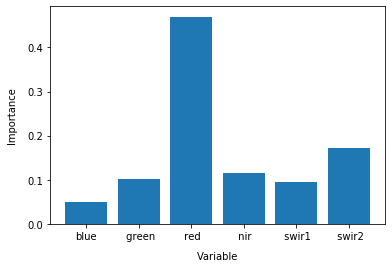

In [67]:
# This shows the feature importance of the input features for predicting the class labels provided
plt.bar(x=model_variables, height=model.feature_importances_)
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Variable', labelpad=10);

This decision tree representation visualises the trained model. 
Here we can see that the model decides which landcover class to assign based on the value of the important variables in the plot above.

The **gini** value shown in the tree represents the decrease in node impurity.
This can also be understood as how heterogeneous the labels are (small values indicating better results). 
This metric is used by the decision tree to determine how to split the data into smaller groups.

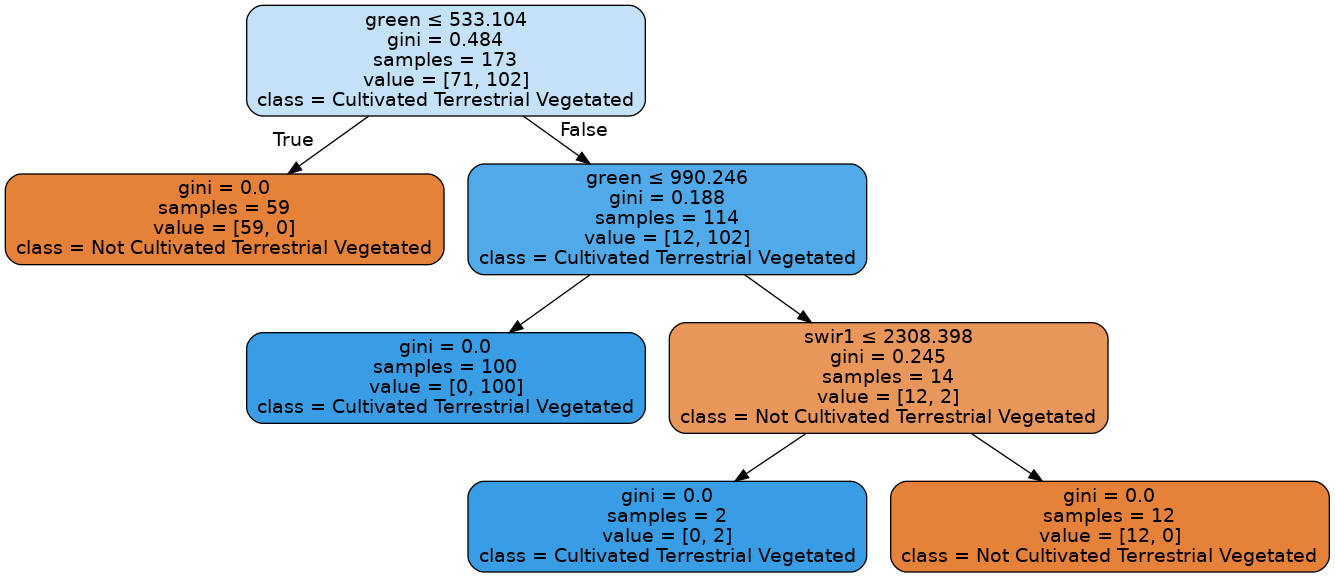

In [14]:
# Prepare a dictionary of class names
class_names = {1: 'Cultivated Terrestrial Vegetated',
               0: 'Not Cultivated Terrestrial Vegetated'}

# Get list of unique classes in model
class_codes = np.unique(model_train[:, 0])
class_names_in_model = [class_names[k] for k in class_codes]

# Plot decision tree
dot_data = StringIO()
tree.export_graphviz(model, 
                     out_file=dot_data, 
                     feature_names=model_variables, 
                     class_names=class_names_in_model,
                     filled=True, 
                     rounded=True,
                     special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Accuracy

We can use the 20% sample of test data we partitioned earlier to test the accuracy of the trained model on this new, "unseen" data.

An accuracy value of 1.0 indicates that the model was able to correctly predict 100% of the classes in the test data.

In [76]:
# Predict test data
predictions = model.predict(model_test[:, model_col_indices])

# Metrics
print('Accuracy = ')
metrics.explained_variance_score(model_test[:, 0], predictions) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html



Accuracy = 


0.8803460576161282

## Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on (e.g. `'ls8_nbart_geomedian_annual'` below).


In [79]:
# Set the central latitude and longitude
central_lat = -36.70287 
central_lon = 145.01171

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [86]:
# Load input data shapefile
input_data = gpd.read_file('../Supplementary_data/Machine_learning_with_ODC/example_training_data.shp')

# Plot first five rows
input_data.head()

,classnum,geometry
0,112,"POLYGON ((-1521875.000 -3801925.000, -1521900...."
1,111,"POLYGON ((-1557925.000 -3801125.000, -1557950...."
2,111,"POLYGON ((-1555325.000 -3800000.000, -1555200...."
3,111,"POLYGON ((-1552925.000 -3800950.000, -1552925...."
4,111,"POLYGON ((-1545475.000 -3800000.000, -1544325...."


In [87]:
# Get extent from input shapefile 
xmin, ymin, xmax, ymax = input_data.unary_union.bounds

# Set up the query parameters
query = {'time': (f'{year}-01-01', f'{year}-12-31'),
         'x': (xmin, xmax),
         'y': (ymin, ymax),
         'crs': 'EPSG:3577',
         'resolution': (-25, 25)}

# Load new input data
geomedian_data = dc.load(product='ls8_nbart_geomedian_annual', 
                         group_by='solar_day', 
                         **query)

In [88]:
geomedian_data

<xarray.Dataset>
Dimensions:  (time: 1, x: 2365, y: 2053)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01
  * y        (y) float64 -3.8e+06 -3.8e+06 -3.8e+06 ... -3.851e+06 -3.851e+06
  * x        (x) float64 -1.559e+06 -1.559e+06 -1.559e+06 ... -1.5e+06 -1.5e+06
Data variables:
    blue     (time, y, x) int16 216 219 228 239 233 257 ... 230 243 266 292 268
    green    (time, y, x) int16 413 415 417 414 388 386 ... 360 375 400 426 409
    red      (time, y, x) int16 301 292 319 338 324 329 ... 328 355 385 411 392
    nir      (time, y, x) int16 2580 2693 2587 2410 2246 ... 2162 2091 2013 2061
    swir1    (time, y, x) int16 1114 1141 1182 1202 1130 ... 1235 1319 1417 1368
    swir2    (time, y, x) int16 489 488 522 555 536 518 ... 549 621 697 779 721
Attributes:
    crs:      EPSG:3577

Once the data has been loaded, we can classify it using `predict_xr`:

In [89]:
# Predict landcover using the trained model
predicted = predict_xr(model, geomedian_data, progress=True)

In [96]:
max(predicted)

<xarray.DataArray (y: 2053, x: 2365)>
array([[0.00136728, 0.00136728, 0.00136728, ..., 0.00136728, 0.00136728,
        0.00136728],
       [0.00136728, 0.00136728, 0.00136728, ..., 0.00136728, 0.00136728,
        0.00136728],
       [0.00136728, 0.00136728, 0.00136728, ..., 0.00136728, 0.00136728,
        0.00136728],
       ...,
       [0.00136728, 0.00136728, 0.00136728, ..., 0.00136728, 0.00136728,
        0.00136728],
       [0.00136728, 0.00136728, 0.00136728, ..., 0.00136728, 0.00136728,
        0.00136728],
       [0.00136728, 0.00136728, 0.00136728, ..., 0.00136728, 0.00136728,
        0.00136728]])
Coordinates:
    time     datetime64[ns] 2017-01-01
  * y        (y) float64 -3.8e+06 -3.8e+06 -3.8e+06 ... -3.851e+06 -3.851e+06
  * x        (x) float64 -1.559e+06 -1.559e+06 -1.559e+06 ... -1.5e+06 -1.5e+06

## Plotting

To qualitatively evaluate how well the classification performed, we can plot the classifed/predicted data next to our input satellite imagery.

> **Note:** The output below is unlikely to be optimal the first time the classification is run.
The model training process is one of experimentation and assumption checking that occurs in an iterative cycle - you may need to revisit the steps above and make changes to model parameters or input training data until you achieve a satisfactory result.

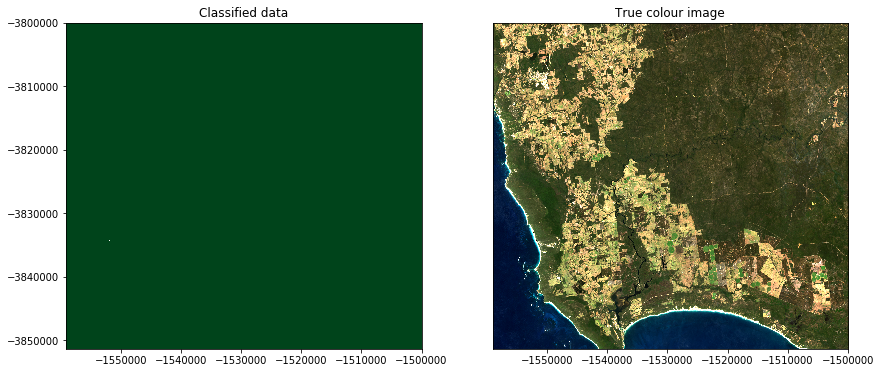

In [90]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot classified image
predicted.plot(ax=axes[0], 
               cmap='Greens', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
(geomedian_data[['red', 'green', 'blue']]
 .squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');

## Exporting classification
We can now export the predicted landcover out to a GeoTIFF `.tif` file. 
This file can be loaded into GIS software (e.g. QGIS, ArcMap) to be inspected more closely.

In [19]:
# Write the predicted data out to a GeoTIFF
predicted = predicted.to_dataset(name="predicted")
predicted = predicted.isel(time=0)
predicted.attrs['crs'] = geometry.CRS("EPSG:3577")
write_geotiff('predicted.tif', predicted)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [20]:
print(datacube.__version__)

1.7+251.g2890b0b1.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)